#### 루브릭
1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?
    - 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.
2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?
    - 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?
    - 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

In [65]:
# 라이브러리 불러오기
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import missingno as msno

# 머신러닝모델 라이브러리
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb



In [76]:
#데이터 경로지정
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)     # 테스트, 즉 submission 시 사용할 데이터 경로

print(train.shape, test.shape)

(15035, 21) (6468, 20)


### EDA

In [77]:
#데이터에서 target 분리
y = train['price'] #타겟을 y에 저장
del train['price'] #타겟을 학습데이터에서 삭제

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [78]:
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [79]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [82]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [86]:
y = np.log1p(y)
y

0        2.588515
1        2.572667
2        2.649161
3        2.599632
4        2.608893
           ...   
15030    2.661820
15031    2.696179
15032    2.624224
15033    2.631833
15034    2.616781
Name: price, Length: 15035, dtype: float64

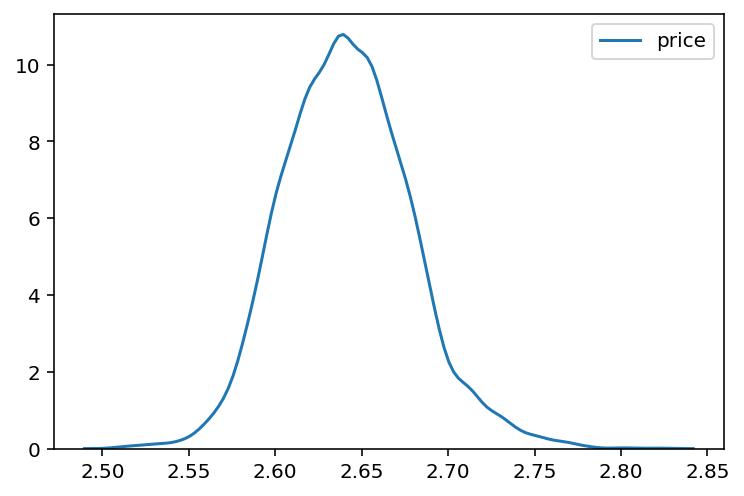

In [87]:
sns.kdeplot(y)
plt.show()

In [81]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

#### 특성 feature 살펴보기
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜  
~3. price : 타겟 변수인 집의 가격 (target)~
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

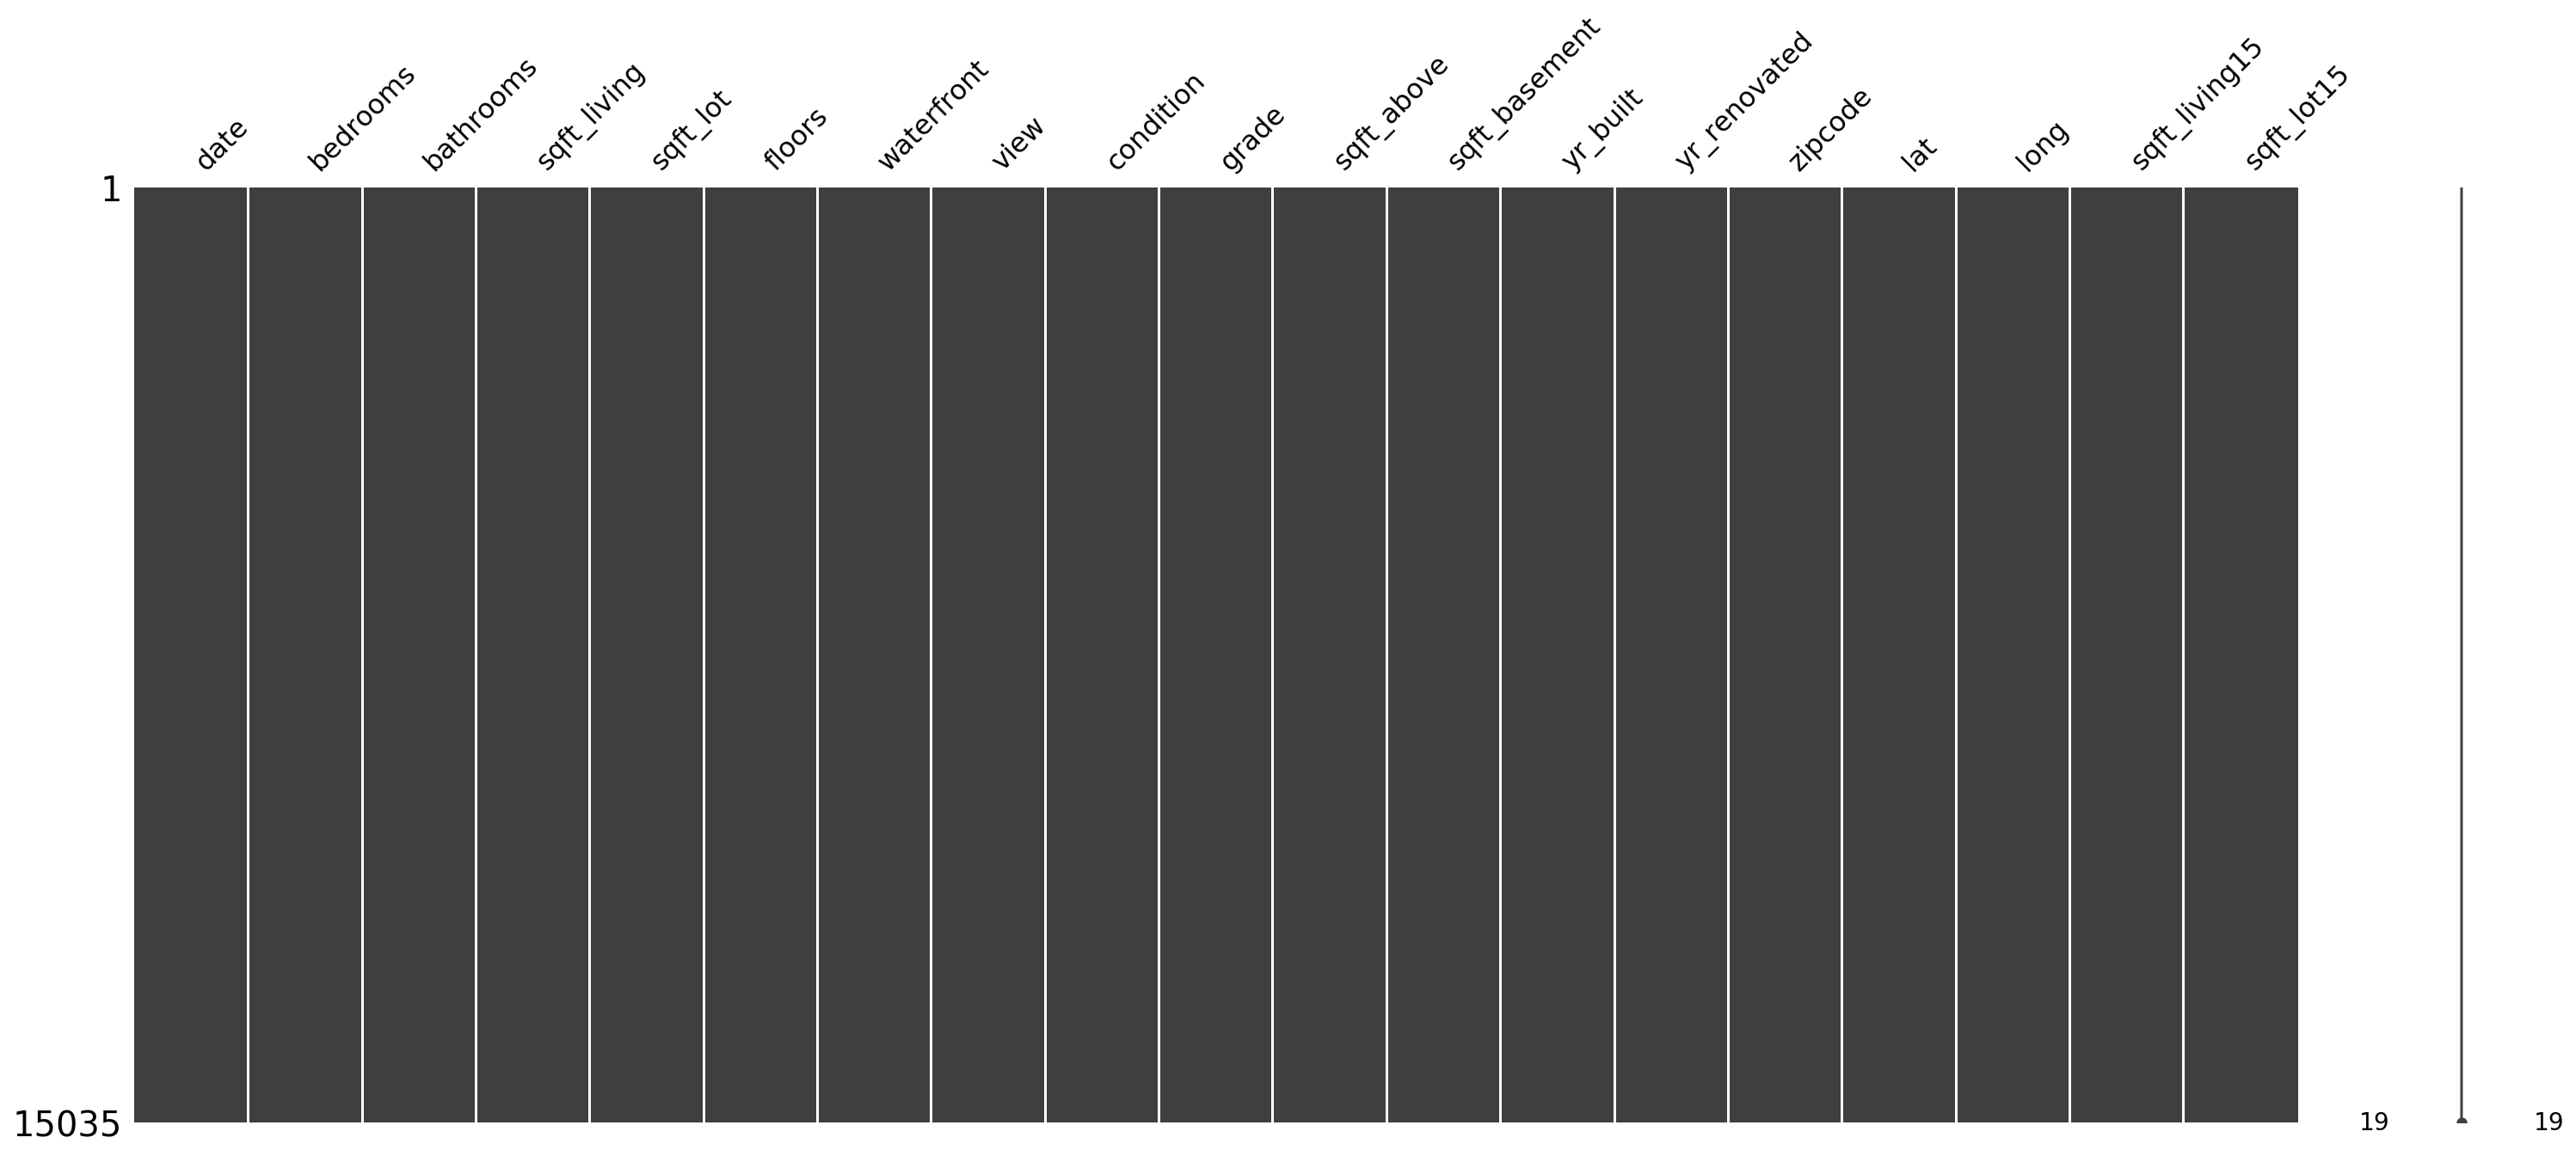

In [89]:
#결측치 확인을 위한 시각화
msno.matrix(train);

In [95]:
# 주요특성들의 분포를 정규분포로 변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)


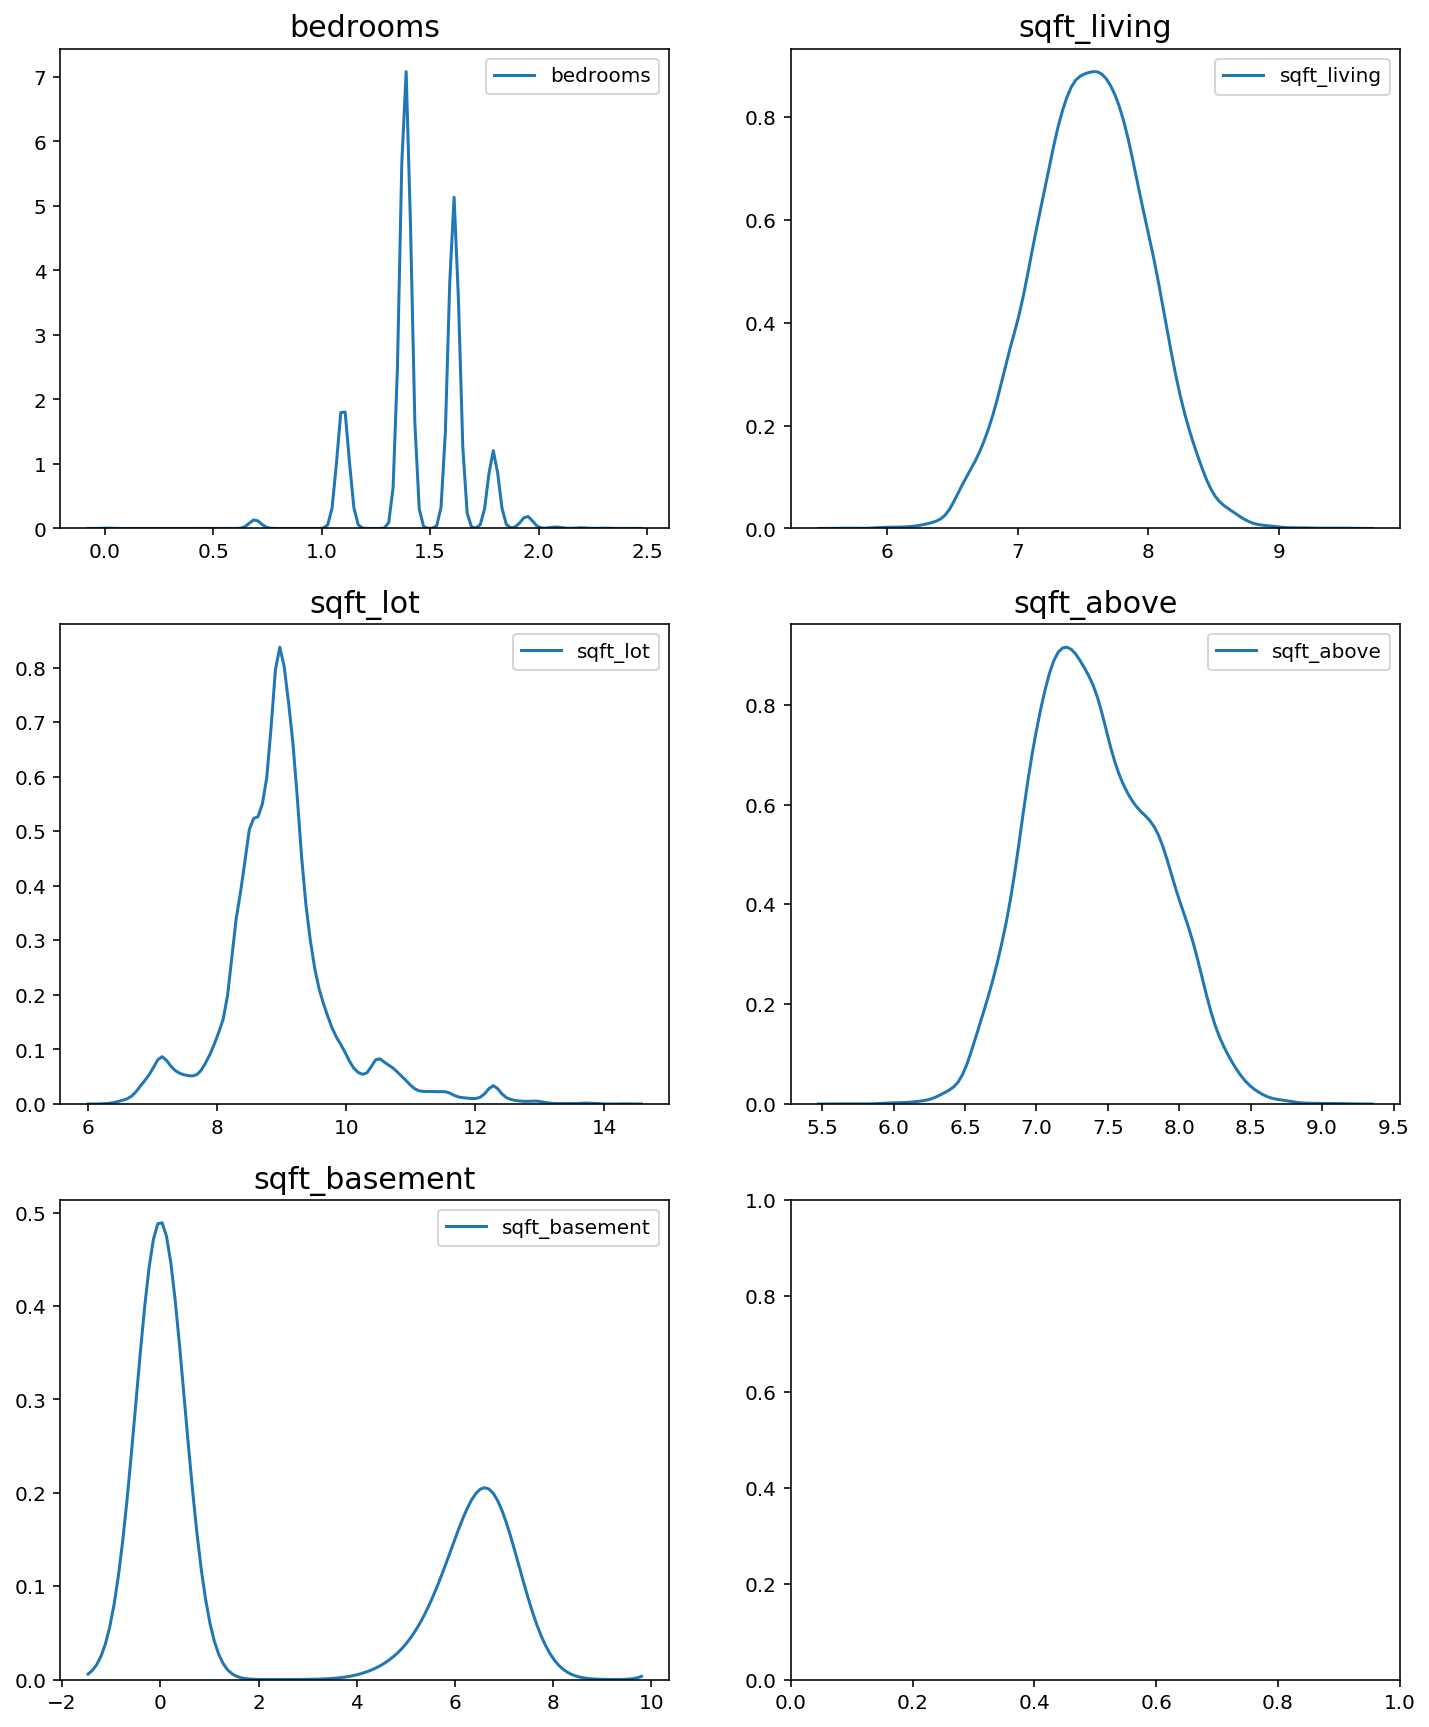

In [96]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

### 훈련데이터/검증데이터 나누기
-모델 훈련시 자동으로 분류하여 학습하므로 생략한다

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [98]:
#캐글 평가지표인 RMSE(평균제곱근편차)변환 함수 선언
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 모델 설계
- 부스팅계열의 모델을 이용하고, 개별 모델의 결과는 각각의 모델의 예측값의 평균으로 산정한다 

In [99]:
#랜덤포레스트 모델 추가
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#모델 생성 
random_state = 42 #랜덤시드 고정변수

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [100]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [73]:
#교차검증(Cross Validation)을 위한 함수선언
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=42).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                                  kf=kfold))

In [74]:
get_cv_score(models) #결정계수 값 반환

AttributeError: 'GradientBoostingRegressor' object has no attribute 'estimators_'

In [102]:
#각각의 모델의 RMSE값을 반환하는 함수 선언
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,0.185268
RandomForestRegressor,0.179938
XGBRegressor,0.173414
LGBMRegressor,0.167670


In [103]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squ

In [104]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12028, 19) (3007, 19) (12028,) (3007,)


In [24]:
#각각의 모델의 평균예측값을 합산하여 평균값을 반환하는 함수 선언
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

### 모델 훈련

In [61]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [105]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    0.6s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011836
2,10,50,-0.000151,0.012278
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019175


In [108]:
#그리드 서치 결과값 반환
grid_model.cv_results_

{'mean_fit_time': array([0.07867002, 0.06336794, 0.11730199, 0.18776422]),
 'std_fit_time': array([0.0114099 , 0.00338227, 0.00722547, 0.01191435]),
 'mean_score_time': array([0.00482516, 0.00583711, 0.00945215, 0.0147687 ]),
 'std_score_time': array([0.00077311, 0.00052328, 0.00149853, 0.00131088]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.00037839, -0.00027917, -0.00014791, -0.00013679]),
 'split1_test_score': array([-0.00038423, -0.00029197, -0.00015652, -0.00014476]),
 'split2_test_score': array([-0.00037037

In [106]:
#주요파라미터 반환
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [107]:
#조합 점수
score = grid_model.cv_results_['mean_test_score']
score

array([-0.00036767, -0.00027739, -0.00015076, -0.0001401 ])

In [110]:
results = pd.DataFrame(params)
results['score'] = score
results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000140,0.011836
2,10,50,-0.000151,0.012278
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019175


### submission 파일생성

In [111]:
#학습, 예측, 경로에 서브미션 파일 생성, 데이터프레임 생성, 적용한 모델명과 스코어를 파일명으로 지정하여 저장

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [112]:
#사용 예시
save_submission(model, train, y, test, 'lgbm', rmsle='0.011836')

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.011836.csv saved!


In [26]:
# #경로 지정
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

# # submission_path = join(data_dir, 'sample_submission.csv')
# # submission = pd.read_csv(submission_path)
# # submission.head()

# #예측값을 id,price로 구성된 데이터프레임 생성
# result = pd.DataFrame({
#     'id' : sub_id, 
#     'price' : y_pred
# })

# result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [27]:
# #지정된 경로로 submission파일 저장
# my_submission_path = join(data_dir, 'submission.csv')
# result.to_csv(my_submission_path, index=False)

# print(my_submission_path)

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


### 모델 평가

#### 회고
- 이번 프로젝트에서 **어려웠던 점,**
    - lms노드를 따라 여러 방법론들을 통해 모델을 구축하였지만 정확하게 모델을 평가하는 방법이나 하이퍼파라미터를 수정하는 방법의 적용이 어려운것 같다.
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
    - 위 내용과 동일하게 부스팅 계열이라는 것은 어떤 특징을 가지고 있는지, 또한 각기 다른 모델을 섞어서 예측값의 평균을 적용할때 정확하게 잘 학습이 이루어진것인지 성능지표만을 보고 판단하기가 어렵다.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
    - 중간에 꼬인 에러를 수정하느라 다양한 시도는 해보지 못했다.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
    - 아마도 models 안에 담긴 여러 모델들을 다 불러와 학습하지 않은것 같다.
    - 파이썬코드에 대한 이해가 부족하여 아직 원하는 방향으로 코드를 수정하지 못하는것 같
- **자기 다짐**
    - 캐글에서 다양한 데이터를 다루고 문제를 정의하는 방법과 적합한 모델을 선정하고 그 모델을 평가하는 방법들에 대한 경험을 더 쌓고싶다.